<a href="https://colab.research.google.com/github/Masquer777/fashion-mnist/blob/main/LENET5_write_box_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.utils.data
from torch import optim, nn
from torchvision import datasets
from torchvision.transforms import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import pickle
import os

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/Fashion-Mnist/black-box")
import LENET5

In [ ]:
def load_data():
    batch_size = 1
    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])

    with open(DATAPATH,"rb") as f:
        attack_data=pickle.load(f)
        attack_datasets=[]
        image=attack_data[0]
        label=attack_data[1]
        for i in range(len(attack_data[0])):
            img=transform(image[i].reshape(28,28))
            attack_datasets.append((img,label[i]))
        #attack_datasets=torch.utils.data.TensorDataset(image,label)
        # label=torch.Tensor(label)
        # attack_datasets=attack_img,label
    test_loader = torch.utils.data.DataLoader(attack_datasets,batch_size=batch_size, shuffle=True)
    return test_loader

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  #sign_data_grad = data_grad.sign()
  
  perturbed_image = image - epsilon*data_grad

  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  
  return perturbed_image

def test( model, device, test_loader, epsilon ):
  final_acc=0
  adv_examples = []
  init_images=[]
  step=0
  # Loop over all examples in test set
  for data, target in test_loader:
    step+=1

    data, target = data.to(device), target.argmax().to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1] 
    if init_pred.item() != target.item():   #本来错误分类的数据，跳过
        step-=1                             #计数减一
        continue
    attack_dict={0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:0}
    expect_label=torch.FloatTensor([attack_dict[target.item()]]).to(device)
    criteon = nn.CrossEntropyLoss().to(device)
    perturbed_data=data
    for _ in range(10):     #退出条件 -- 迭代次数
          
      #更新梯度
      attack_output=model(perturbed_data)
      loss = criteon(attack_output,expect_label.long())
      model.zero_grad()
      loss.backward(retain_graph =True)
      data_grad = data.grad.data             
      
      #更新对抗样本
      perturbed_data = fgsm_attack(perturbed_data, epsilon, data_grad)
      attack_output = model(perturbed_data)
      final_pred = attack_output.max(1, keepdim=True)[1]

      #判断是否攻击成功
      if final_pred.item() == expect_label.item():
        final_acc+=1
        print(" {}/{} : attack finished  {}  ...".format(step,totel_test_examples, final_acc))

        #保存数据为list
        adv_examples.append((perturbed_data,target.item(),expect_label.item()))
        init_images.append((data,target.item()))
        break
    if step > totel_test_examples:
      break

    # Return the adversarial example
  return final_acc,adv_examples,init_images

In [ ]:

def show_attack_img(data):
    for step,i in enumerate(data):
        adv_ex = i[0].squeeze().detach().cpu().numpy()
        init_label=i[1]
        expect_label=i[2]
        print("{} / {}".format((step+1),len(data)),end="\r")
        plt.imshow(adv_ex, cmap="gray")
#         print(step)
#         print(init_label)
        plt.savefig(SAVEPATH+"/NO{}_fashion-mnist_{}to{}.jpg".format(step+1,init_label,expect_label))

def show_init_img(data):
    for step,i in enumerate(data):
        adv_ex = i[0].squeeze().detach().cpu().numpy()
        init_label=i[1]
        print("{} / {}".format((step+1),len(data)),end="\r")
        plt.imshow(adv_ex, cmap="gray")
        plt.savefig(SAVEPATH+"/NO{}_fashion-mnist_{}.jpg".format(step+1,init_label))

def save_dict(data, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


this model is runing in GPU
 10/1000 : attack finished  1  ...
 40/1000 : attack finished  2  ...
 51/1000 : attack finished  3  ...
 53/1000 : attack finished  4  ...
 56/1000 : attack finished  5  ...
 63/1000 : attack finished  6  ...
 65/1000 : attack finished  7  ...
 66/1000 : attack finished  8  ...
 85/1000 : attack finished  9  ...
 88/1000 : attack finished  10  ...
 89/1000 : attack finished  11  ...
 91/1000 : attack finished  12  ...
 95/1000 : attack finished  13  ...
 98/1000 : attack finished  14  ...
 99/1000 : attack finished  15  ...
 103/1000 : attack finished  16  ...
 104/1000 : attack finished  17  ...
 116/1000 : attack finished  18  ...
 123/1000 : attack finished  19  ...
 140/1000 : attack finished  20  ...
 143/1000 : attack finished  21  ...
 145/1000 : attack finished  22  ...
 147/1000 : attack finished  23  ...
 151/1000 : attack finished  24  ...
 164/1000 : attack finished  25  ...
 167/1000 : attack finished  26  ...
 174/1000 : attack finished  27  .

FileNotFoundError: ignored

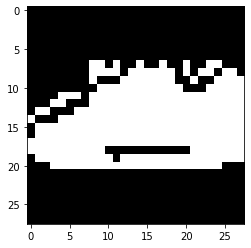

In [ ]:
if __name__=="__main__":

  SAVEPATH="/content/drive/MyDrive/Fashion-Mnist/black-box/write-box-data-LENET5"             #文件保存路径
  MODELPATH="/content/drive/MyDrive/Fashion-Mnist/black-box/Lenet5_acc_91.59.pkl"           #加载模型路径
  DATAPATH="/content/drive/MyDrive/Fashion-Mnist/attack_data/correct_1k.pkl"           #加载数据路径

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print("this model is runing in "+"GPU" if torch.cuda.is_available() else "CPU")
  net=torch.load(MODELPATH)
  net.eval()

  eps=0.05      
  attack_datasets=load_data()
  totel_test_examples=len(attack_datasets)
  acc,ex,init_img = test(net, device, attack_datasets, eps)

  res=SAVEPATH+"/write_attack_info.txt"
  f=open(res,"w+")
  f.write("The accuracy of this model in the test set is 91.59 %\n")
  f.write("Success rate of white box attack is  {:.2f}% \n".format(100.*acc/totel_test_examples))
  f.close()
  save_dict(ex,SAVEPATH+"/adv_ex")
  save_dict(init_img,SAVEPATH+"/init_img")

  show_attack_img(ex)
  show_init_img(init_img)

In [ ]:
res=SAVEPATH+"/write_attack_info.txt"
f=open(res,"w+")
f.write("The accuracy of this model in the test set is 91.59 %\n")
f.write("Success rate of white box attack is  {:.2f}% \n".format(100.*acc/totel_test_examples))
f.close()

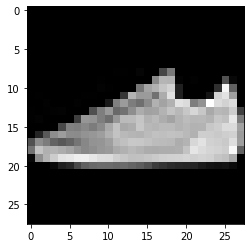

In [ ]:
show_attack_img(ex)
show_init_img(init_img)